# Microsoft Malware Challenge

## LightGBM - baseline

## For CSCE 633 Machine Learning, Spring 2019, Course project
### Team: MARTHA
### Author: Rose Lin

This is the third notebook in the series. After the baseline SVM model, finally we are trying the famous lightGBM model that everybody has been using in the competition. It's inspired by 

* [Theo Viel's kernel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data)
* [Vladislav Bogorod's Kernel](https://www.kaggle.com/bogorodvo/lightgbm-baseline-model-using-sparse-matrix)

Stratified K-Fold took too long to run, so I am just doing a normal train-test-split here. (There is a kernel stating that the hidden test data is more "fresh", i.e. the dates are closer to today. So I might try to improve that as well)

~Ongoing efforts, your feedback is appreciated!~

## Initial setup

Loading data, packages, etc.

In [0]:
# load the data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
#import json

#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import gc
gc.enable()

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [0]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
print('Download Train and Test Data.\n')
train = reduce_mem_usage(pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/train.csv', dtype=dtypes, low_memory=True))
train['MachineIdentifier'] = train.index.astype('uint32')
test  = reduce_mem_usage(pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/test.csv',  dtype=dtypes, low_memory=True))
test['MachineIdentifier']  = test.index.astype('uint32')

gc.collect()

Download Train and Test Data.

Mem. usage decreased to 1673.25 Mb (0.0% reduction)
Mem. usage decreased to 1503.79 Mb (0.0% reduction)


201404

## Feature Engineering

Only run this if you don't have saved the transformed features already (otherwise jump to [this cell](https://colab.research.google.com/drive/1z0ZTYQZli9i8182ZagFI6LTlOH7tiZbD#scrollTo=I4maN32BRBpM)). Basically it's transforming all the features into categorical variables, with missing values being marked as 0.

!Question: is it okay that we peak into test data here?

In [0]:
print('Transform all features to category.\n')
counter = 0

for usecol in train.columns.tolist()[1:-1]:

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    if counter % 5 == 0:
       print("Transformed",counter,"features.")
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]

    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()
    
    counter += 1

Transform all features to category.

Transformed 0 features.
Transformed 5 features.
Transformed 10 features.
Transformed 15 features.
Transformed 20 features.
Transformed 25 features.
Transformed 30 features.
Transformed 35 features.
Transformed 40 features.
Transformed 45 features.
Transformed 50 features.
Transformed 55 features.
Transformed 60 features.
Transformed 65 features.
Transformed 70 features.
Transformed 75 features.
Transformed 80 features.


In [0]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier']
gc.collect()

21

All we need is just the *y_train*, *train_ids* and *test_ids*. To free up memory the original dataframes can be removed.

In [0]:
# skip this line of code if you have not run one hot encoding before
del train, test
gc.collect()

406

Skip the one hot encoding below if the data has already been saved.

Sparse matrices are used here to save memory, plus sparsity actually conveys more information (lower entropy). It's combined with one-hot encoding.

In [0]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)

#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m + 1)])

save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train.npz', train, compressed=True)
save_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test.npz',  test,  compressed=True)

del ohe, train, test
gc.collect()

2296

In [0]:
# Don't run this cell unless you have really large memory!
#train = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train.npz')
#test = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test.npz')

Now Build the stratified K-Fold model (as the traditional train-test-split will cause OOM).

In [0]:
from datetime import datetime

now = datetime.now() # current date and time
today_string = now.strftime("%m-%d-%Y")
print("Today's string:",today_string)	

Today's string: 04-05-2019


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

counter = 0
m = 100000

print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    train = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/train.npz')
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    
    del train
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**12-1,
                                   colsample_bytree=0.28,
                                   objective='binary', 
                                   n_jobs=-1)
                               
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    print("\nDumping out the model persistence as pickles.")
    # dump model with pickle
    with open('/content/gdrive/My Drive/Coding experiment/MARTHA/Models/Checkpoints/lightgbm_'+today_string+'_'+str(counter)+'.pkl', 'wb') as fout:
        pickle.dump(lgb_model, fout)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    counter += 1


LightGBM

Fold 1

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.731814	valid_0's binary_logloss: 0.604756
[200]	valid_0's auc: 0.737255	valid_0's binary_logloss: 0.598171
[300]	valid_0's auc: 0.738762	valid_0's binary_logloss: 0.596577
[400]	valid_0's auc: 0.73902	valid_0's binary_logloss: 0.596246
[500]	valid_0's auc: 0.738941	valid_0's binary_logloss: 0.596295
Early stopping, best iteration is:
[413]	valid_0's auc: 0.739032	valid_0's binary_logloss: 0.596234

Dumping out the model persistence as pickles.
Fold 2

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.732085	valid_0's binary_logloss: 0.604716
[200]	valid_0's auc: 0.737355	valid_0's binary_logloss: 0.598296
[300]	valid_0's auc: 0.738891	valid_0's binary_logloss: 0.596623
[400]	valid_0's auc: 0.739114	valid_0's binary_logloss: 0.596321
Early stopping, best iteration is:
[392]	valid_0's auc: 0.739125	valid_0's binary_logloss: 0.596318

Dumping out the

## Generating predictions

Now the fun part begins! (Assuming that the test data has been transformed and saved already.)

In [0]:
test = load_npz('/content/gdrive/My Drive/Coding experiment/MARTHA/test.npz')
test = csr_matrix(test, dtype='float32')

In [0]:
submission = pd.read_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/sample_submission.csv')
lgb_test_result_1  = np.zeros(submission['MachineIdentifier'].shape[0])

In [0]:
from os import listdir
from os.path import isfile, join

folder_path = '/content/gdrive/My Drive/Coding experiment/MARTHA/Models/Checkpoints/'

print("\nLightGBM - Prediction\n")

for f in listdir(folder_path):
  print("Loading saved model pickle file:",f)
  saved_model_path = join(folder_path,f)
  
  with open(saved_model_path, 'rb') as fin:
    lgb_model = pickle.load(fin)
  lgb_test_result_1 += lgb_model.predict_proba(test)[:,1]
  print("Result saved.\n")
  
  del lgb_model
  gc.collect()


LightGBM - Prediction

Loading saved model pickle file: lightgbm_04-05-2019_0.pkl
Result saved.

Loading saved model pickle file: lightgbm_04-05-2019_1.pkl
Result saved.

Loading saved model pickle file: lightgbm_04-05-2019_2.pkl
Result saved.

Loading saved model pickle file: lightgbm_04-05-2019_3.pkl
Result saved.

Loading saved model pickle file: lightgbm_04-05-2019_4.pkl
Result saved.



In [0]:
# divided by 5 coz there are 5 models.
submission['HasDetections'] = lgb_test_result_1 / 5
submission.to_csv('/content/gdrive/My Drive/Coding experiment/MARTHA/data/lgb_submission.csv', index=False)

## More exploration on the Trained GBM models

The lightGBM package comes with some functionalities to allow us to poke around and see what the trained models have learned. Below are some test codes.


LightGBM - Model characteristics

Loading saved model pickle file: lightgbm_04-05-2019_0.pkl
Num of features used: 7739
Plotting feature importances...


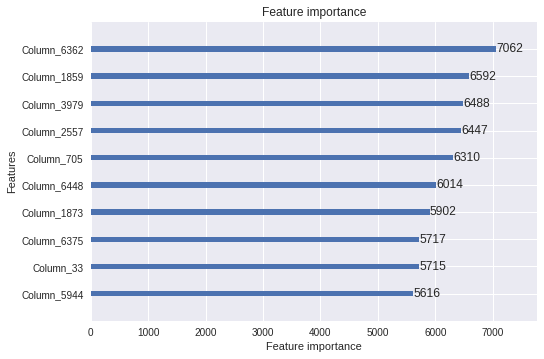

Feature importances: [0, 208, 173, 3110, 86, 207, 104, 117, 99, 218, 144, 628, 146, 115, 132, 202, 222, 287, 839, 295, 103, 478, 735, 926, 1690, 36, 29, 828, 1355, 43, 1752, 99, 1689, 5715, 756, 140, 359, 201, 276, 757, 151, 33, 857, 746, 796, 818, 2968, 343, 679, 1170, 1705, 345, 2350, 95, 57, 996, 1210, 1382, 42, 284, 21, 10, 38, 15, 481, 65, 14, 80, 854, 117, 651, 296, 165, 233, 53, 66, 60, 53, 70, 76, 3504, 518, 666, 29, 46, 34, 31, 66, 934, 37, 20, 57, 28, 48, 23, 27, 31, 41, 42, 30, 32, 38, 25, 26, 13, 18, 18, 72, 31, 33, 28, 36, 41, 21, 35, 25, 26, 24, 50, 55, 58, 40, 41, 38, 26, 34, 22, 29, 22, 27, 37, 75, 16, 47, 23, 43, 38, 30, 19, 46, 25, 32, 69, 24, 90, 31, 41, 37, 54, 60, 31, 40, 97, 70, 42, 37, 34, 55, 65, 47, 31, 62, 29, 39, 83, 16, 76, 33, 53, 17, 28, 25, 37, 59, 29, 25, 85, 19, 33, 14, 33, 109, 19, 32, 135, 24, 46, 46, 24, 52, 46, 30, 77, 36, 59, 33, 28, 35, 29, 39, 76, 47, 40, 33, 23, 45, 64, 87, 44, 51, 29, 52, 27, 79, 356, 41, 196, 133, 265, 118, 139, 132, 180, 61, 

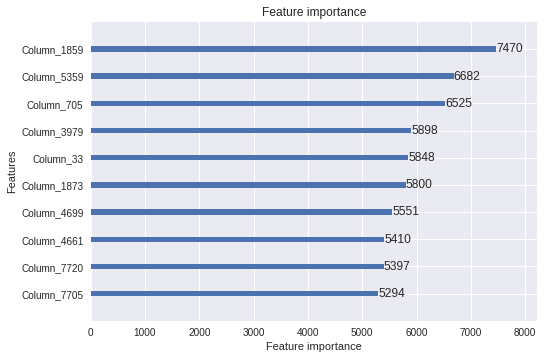

Feature importances: [1, 206, 183, 2008, 76, 149, 92, 105, 89, 199, 204, 706, 176, 98, 129, 243, 234, 250, 891, 257, 109, 467, 529, 686, 1750, 40, 24, 787, 1202, 35, 1655, 73, 1673, 5848, 643, 125, 391, 225, 250, 736, 136, 18, 838, 660, 736, 1062, 2646, 341, 845, 1099, 2247, 288, 2244, 63, 49, 664, 1266, 1642, 24, 308, 26, 7, 27, 30, 605, 61, 14, 115, 634, 99, 870, 331, 136, 210, 58, 47, 49, 51, 52, 68, 3426, 502, 557, 17, 32, 30, 19, 72, 968, 41, 15, 71, 19, 38, 27, 22, 41, 23, 46, 22, 25, 32, 30, 27, 9, 12, 17, 57, 27, 53, 51, 31, 34, 19, 35, 26, 19, 23, 49, 56, 59, 36, 38, 30, 16, 26, 16, 36, 28, 11, 42, 79, 20, 28, 22, 43, 55, 43, 15, 42, 23, 16, 73, 28, 70, 42, 27, 29, 52, 45, 19, 33, 84, 72, 25, 27, 24, 55, 42, 38, 26, 58, 25, 50, 104, 24, 49, 34, 26, 33, 27, 26, 33, 30, 28, 29, 95, 18, 25, 17, 24, 76, 42, 43, 126, 19, 39, 39, 18, 45, 39, 41, 60, 32, 39, 34, 24, 44, 21, 24, 47, 42, 34, 34, 20, 25, 54, 93, 38, 29, 18, 51, 26, 44, 438, 27, 186, 119, 275, 82, 152, 108, 157, 66, 46, 

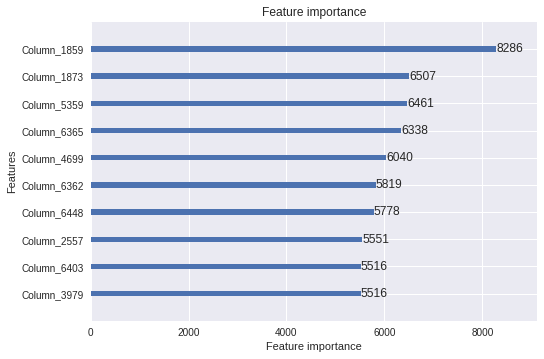

Feature importances: [0, 238, 231, 2935, 89, 162, 78, 79, 94, 208, 195, 632, 163, 95, 141, 193, 197, 282, 850, 261, 105, 419, 708, 922, 1683, 32, 20, 784, 1251, 40, 1687, 72, 1986, 4051, 837, 133, 336, 259, 258, 745, 176, 20, 657, 828, 781, 960, 2979, 283, 740, 1199, 2054, 377, 2306, 100, 58, 910, 1153, 1558, 27, 263, 19, 19, 27, 29, 533, 69, 21, 72, 740, 110, 722, 324, 152, 197, 83, 54, 58, 64, 85, 68, 3207, 500, 554, 24, 32, 33, 24, 60, 884, 37, 23, 68, 24, 31, 13, 19, 42, 26, 43, 43, 28, 36, 27, 22, 27, 19, 15, 64, 25, 39, 44, 22, 42, 21, 32, 34, 29, 21, 53, 48, 61, 37, 33, 25, 34, 23, 24, 25, 24, 13, 43, 78, 14, 42, 28, 31, 55, 27, 15, 54, 18, 28, 79, 24, 83, 55, 30, 27, 50, 55, 31, 43, 93, 78, 46, 23, 23, 50, 50, 25, 21, 51, 37, 50, 70, 15, 46, 30, 22, 25, 25, 34, 34, 52, 27, 19, 92, 29, 28, 25, 16, 89, 38, 26, 115, 22, 29, 45, 21, 44, 36, 31, 68, 31, 32, 33, 34, 35, 24, 30, 58, 40, 33, 40, 20, 28, 76, 90, 37, 47, 11, 31, 22, 62, 482, 38, 165, 142, 308, 89, 149, 125, 177, 67, 74, 

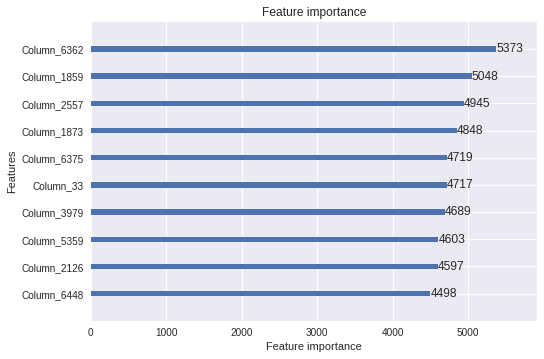

Feature importances: [0, 185, 160, 2299, 78, 194, 104, 83, 106, 177, 142, 462, 161, 87, 91, 172, 186, 255, 657, 238, 111, 391, 652, 839, 1487, 32, 35, 774, 1161, 34, 1607, 94, 1359, 4717, 754, 139, 323, 191, 247, 749, 127, 18, 704, 691, 730, 714, 2654, 307, 606, 1022, 1474, 334, 2160, 74, 48, 889, 973, 1065, 38, 238, 18, 11, 36, 15, 402, 71, 7, 83, 685, 107, 501, 265, 143, 217, 46, 51, 52, 47, 66, 85, 2936, 434, 589, 25, 20, 33, 26, 70, 865, 49, 19, 52, 22, 29, 18, 20, 30, 13, 41, 39, 29, 31, 20, 18, 16, 9, 22, 51, 15, 30, 30, 31, 20, 6, 32, 17, 34, 17, 40, 56, 55, 37, 42, 23, 21, 26, 15, 29, 13, 11, 36, 62, 8, 33, 22, 40, 32, 30, 10, 42, 21, 25, 85, 27, 75, 27, 28, 39, 44, 37, 22, 36, 72, 86, 43, 28, 26, 58, 45, 34, 30, 53, 29, 43, 74, 12, 58, 28, 20, 33, 25, 27, 27, 41, 23, 15, 95, 21, 25, 17, 15, 90, 37, 27, 88, 25, 42, 48, 13, 36, 47, 18, 52, 37, 28, 33, 22, 39, 23, 26, 74, 30, 43, 38, 22, 43, 61, 84, 46, 42, 35, 58, 20, 58, 326, 28, 172, 124, 247, 97, 120, 97, 154, 51, 71, 61, 118

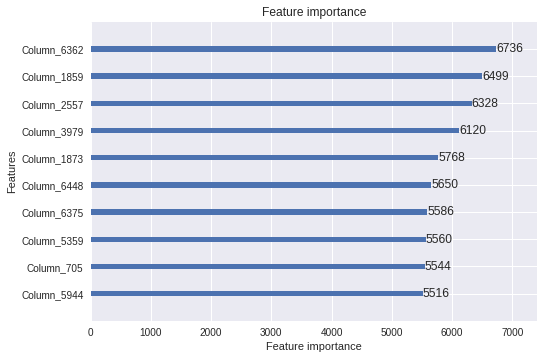

Feature importances: [2, 194, 175, 2861, 82, 180, 112, 97, 90, 189, 185, 547, 142, 87, 91, 219, 232, 293, 822, 302, 98, 395, 734, 954, 1704, 49, 18, 847, 1344, 38, 1731, 90, 1639, 5383, 761, 124, 360, 212, 256, 751, 156, 22, 813, 787, 779, 869, 2813, 333, 618, 1199, 1623, 368, 2375, 93, 52, 999, 1218, 1275, 41, 264, 19, 15, 28, 19, 491, 54, 14, 78, 858, 102, 568, 268, 148, 235, 70, 52, 56, 58, 69, 75, 3271, 492, 600, 19, 27, 34, 28, 75, 910, 38, 10, 57, 23, 36, 21, 18, 33, 23, 47, 25, 10, 47, 36, 20, 21, 16, 25, 57, 22, 39, 34, 32, 37, 21, 28, 34, 48, 32, 70, 39, 53, 34, 54, 26, 16, 40, 30, 35, 13, 23, 40, 87, 17, 52, 26, 31, 39, 33, 24, 52, 22, 18, 74, 24, 85, 30, 34, 36, 67, 33, 26, 24, 87, 67, 35, 18, 34, 51, 52, 28, 24, 48, 39, 58, 88, 17, 81, 33, 27, 20, 26, 24, 21, 34, 32, 10, 92, 33, 19, 17, 23, 102, 32, 32, 123, 26, 36, 47, 11, 49, 53, 39, 55, 49, 44, 42, 49, 39, 23, 44, 47, 44, 40, 39, 17, 32, 58, 85, 45, 45, 32, 70, 33, 64, 373, 33, 155, 135, 220, 90, 163, 120, 179, 85, 79, 6

In [0]:
from os import listdir
from os.path import isfile, join

folder_path = '/content/gdrive/My Drive/Coding experiment/MARTHA/Models/Checkpoints/'

print("\nLightGBM - Model characteristics\n")

for f in listdir(folder_path):
  print("Loading saved model pickle file:",f)
  saved_model_path = join(folder_path,f)
  
  with open(saved_model_path, 'rb') as fin:
    lgb_model = pickle.load(fin)
  
  print('Num of features used:', lgb_model.n_features_)
  print('Plotting feature importances...')
  ax = lgb.plot_importance(lgb_model, max_num_features = 10)
  plt.show()
    
  # feature importances
  print('Feature importances:', list(lgb_model.feature_importances_))
  print('Feature names:', lgb_model.booster_.feature_name())
  print("")

The question now is: we don't know how to translate the feature back to the original features provided in the dataset. Looks like the one-hot encoding creates 8929224 features in total, but only 7739 are used. Still trying to figure out how to do the translation.

In [0]:
del test
gc.collect()

#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)
#m = 100000
#train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])

In [0]:
l = ohe.get_feature_names()
print(len(l))
print(l)

8929224
['x0_0' 'x0_1' 'x0_2' ... 'x81_16' 'x82_0' 'x82_1']


In [0]:
print(l[7740])

x0_7740


In [0]:
train_sample_1 = vstack(ohe.transform(train.ix[0:1]))
train_sample_1

<2x8929224 sparse matrix of type '<class 'numpy.uint8'>'
	with 166 stored elements in Compressed Sparse Row format>